#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     TimeSeriesSplit)

from statsmodels.tsa.seasonal import seasonal_decompose 

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [2]:
# константы
RANDOM_STATE = 12345
# определим метрику расчитываемую при кросс-валидации
SCORER = 'neg_mean_squared_error'
# разбиение на выборки с очерёдностью по времени
TSS = TimeSeriesSplit(n_splits = 5)

In [3]:
try:
    taxi_data = pd.read_csv('/datasets/taxi.csv')
except:
    taxi_data = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Модуль 3\\Временные ряды\\taxi.csv')

In [4]:
# функция для вывода основной информации о данных
def data_research1(data):
    display(data.head())
    print()
    data.info()
    print()
    print('Пропуски:', data.isna().sum().sum(), 'это {:.2%} от всех данных.'
          .format(data.isna().sum().sum() / (data.shape[0] * data.shape[1])))
    print()
    print('Процент (%) пропусков в каждой категории данных.')
    display((data.isna().sum() / data.shape[0]) * 100)
    print()
    print('Явные дубликаты:', data.duplicated().sum(), 'это {:.2%} от всех данных.'
          .format(data.duplicated().sum() / data.shape[0]))
    
    # строим график распределения 
    data.hist(bins=100,figsize=(30, 10))

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

Пропуски: 0 это 0.00% от всех данных.

Процент (%) пропусков в каждой категории данных.


datetime      0.0
num_orders    0.0
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.


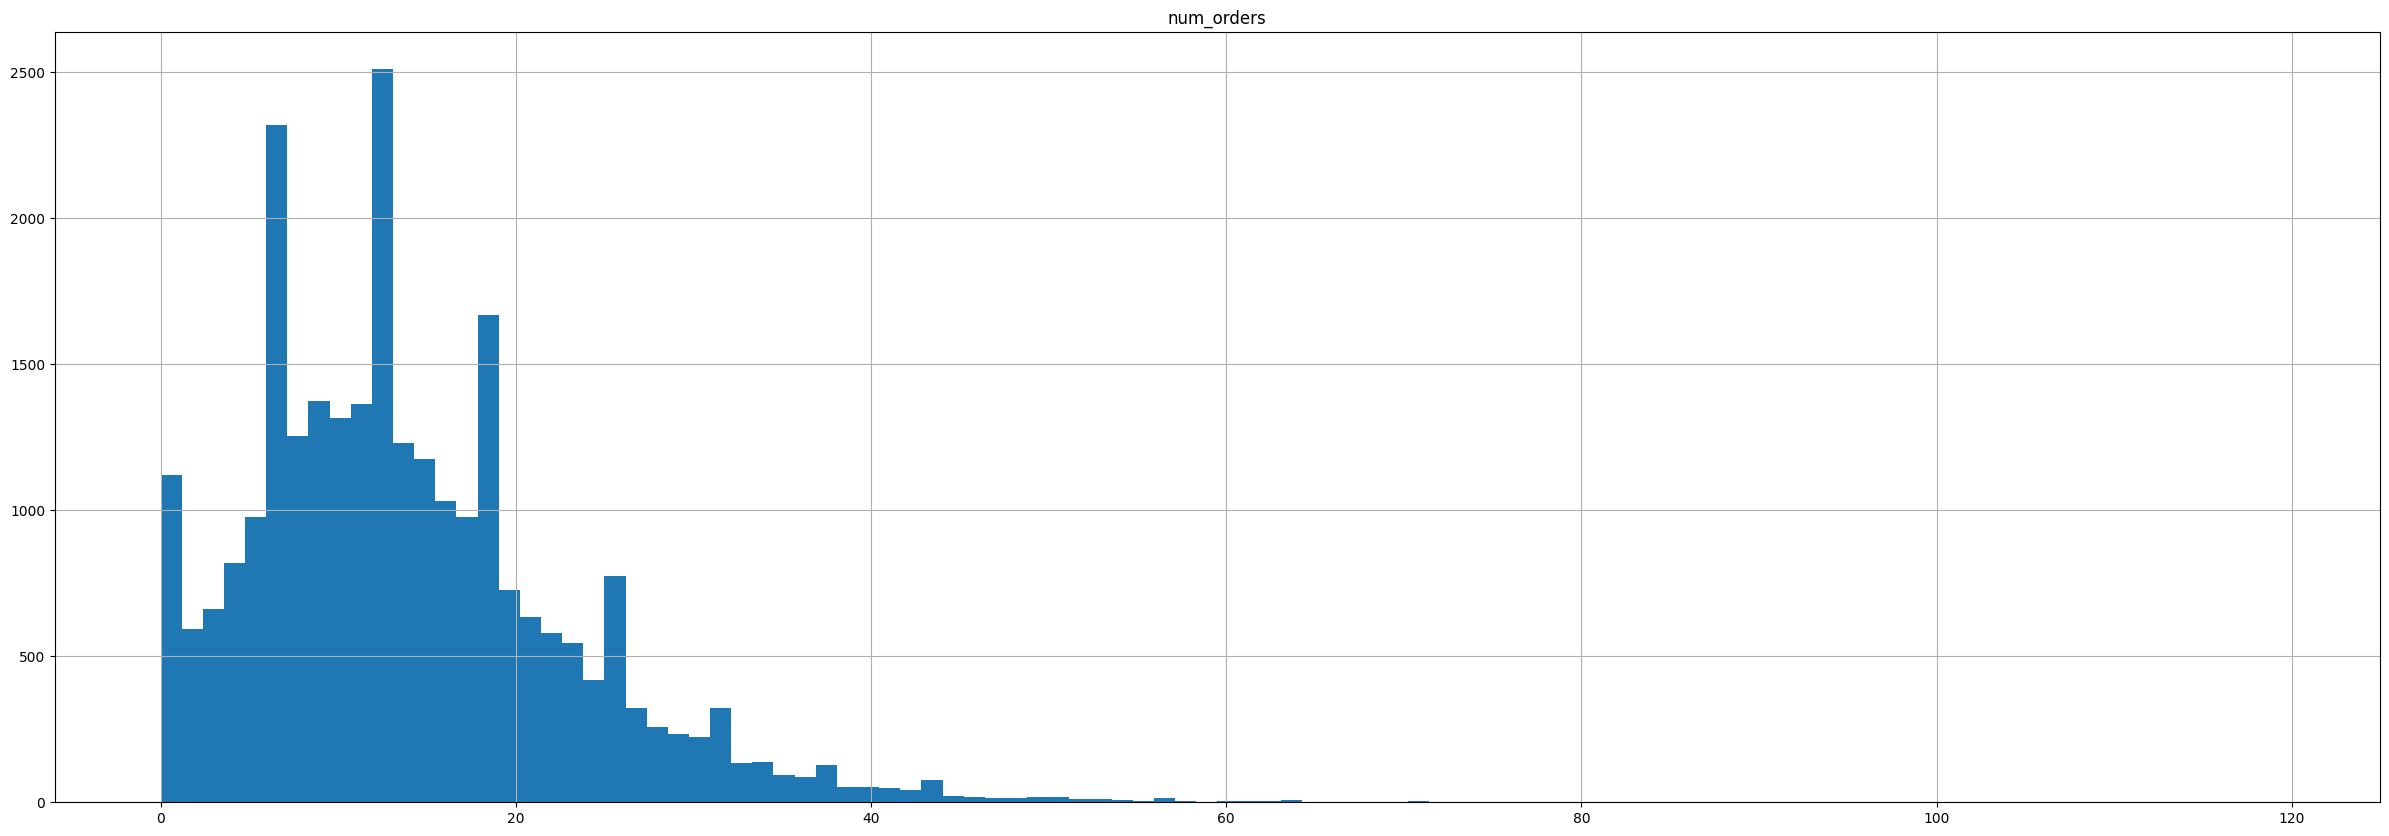

In [5]:
data_research1(taxi_data)

Данные хорошо оформлены, не имеют пропусков и дубликатов. Присутствуют аномалии в виде выбросов на фоне нормального распределения и хвост из высоких значений,  изучим это подробней разложив данные на временной шкале.

Переведем информацию о времени из текста во временные показатели,  сделаем их индексами и проверим соблюдена ли последовательность.

In [6]:
# переведем object в datetime64
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])
# произведем индексацию по столбцу datetime 
taxi_data = taxi_data.set_index('datetime')

In [7]:
# проверим соблюдена ли  последовательность
taxi_data.index.is_monotonic_increasing

True

Данные расположены по порядку.

## Анализ

Будем анализировать как меняется количество заказов по часам.

In [8]:
# cсумируем количество заказов по часам
taxi_data=taxi_data.resample('1H').sum()
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
# все изменения, производимые с данными, вынесем в отдельный блок
taxi_data_analysis = taxi_data.copy(deep=True)

In [10]:
# разложение временного ряда на тренд, сезонность и остаток
decomposed = seasonal_decompose(taxi_data_analysis)

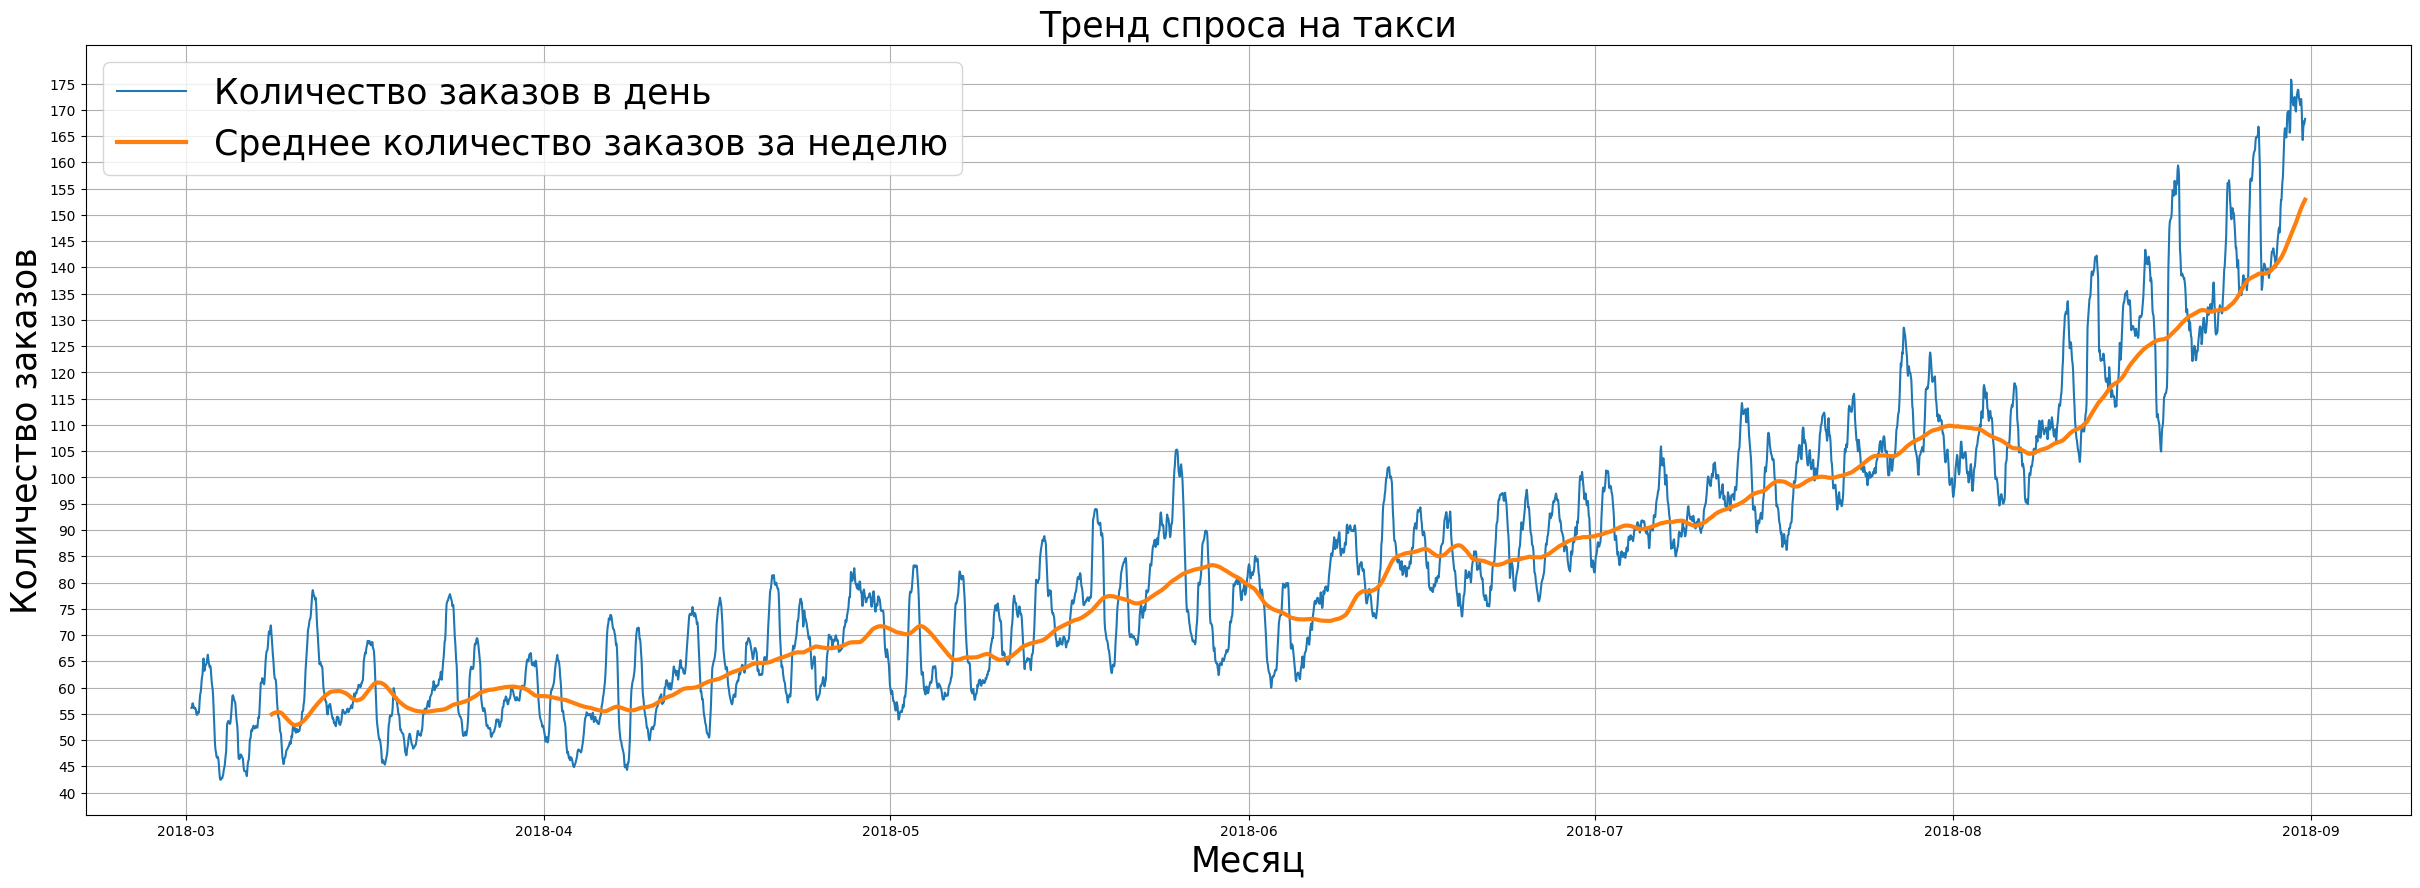

In [11]:
plt.figure(figsize=(30, 10))
plt.plot(decomposed.trend)
plt.plot(decomposed.trend.rolling(24*7).mean() , linewidth=3)
plt.legend(['Количество заказов в день', 'Среднее количество заказов за неделю'], fontsize=25)
plt.title('Тренд спроса на такси', fontsize=25)
plt.xlabel('Месяц', fontsize=25)
plt.ylabel('Количество заказов', fontsize=25)
plt.yticks(np.arange(40, 180, 5))
plt.grid()
plt.show()

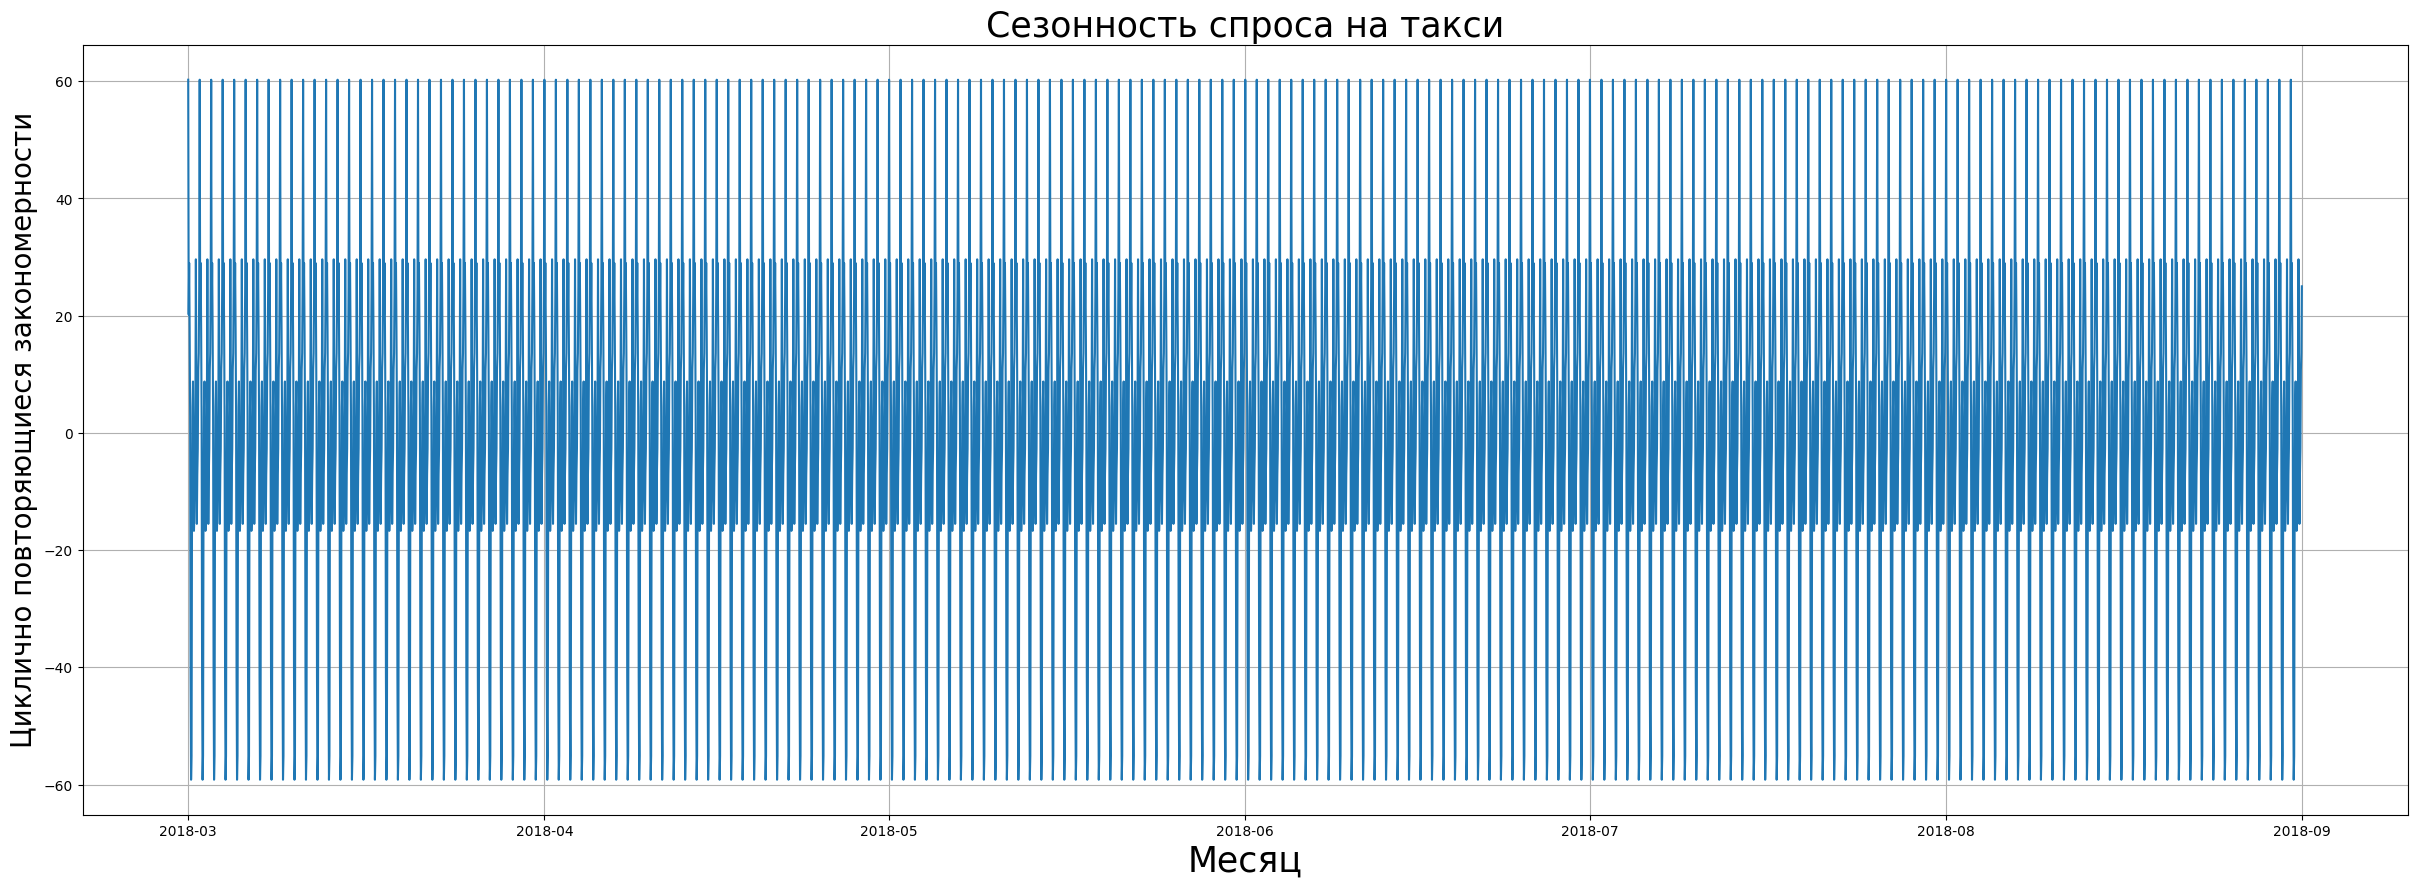

In [12]:
plt.figure(figsize=(30, 10))
plt.plot(decomposed.seasonal)
plt.title('Сезонность спроса на такси', fontsize=25)
plt.xlabel('Месяц', fontsize=25)
plt.ylabel('Циклично повторяющиеся закономерности', fontsize=20)
plt.grid()
plt.show()

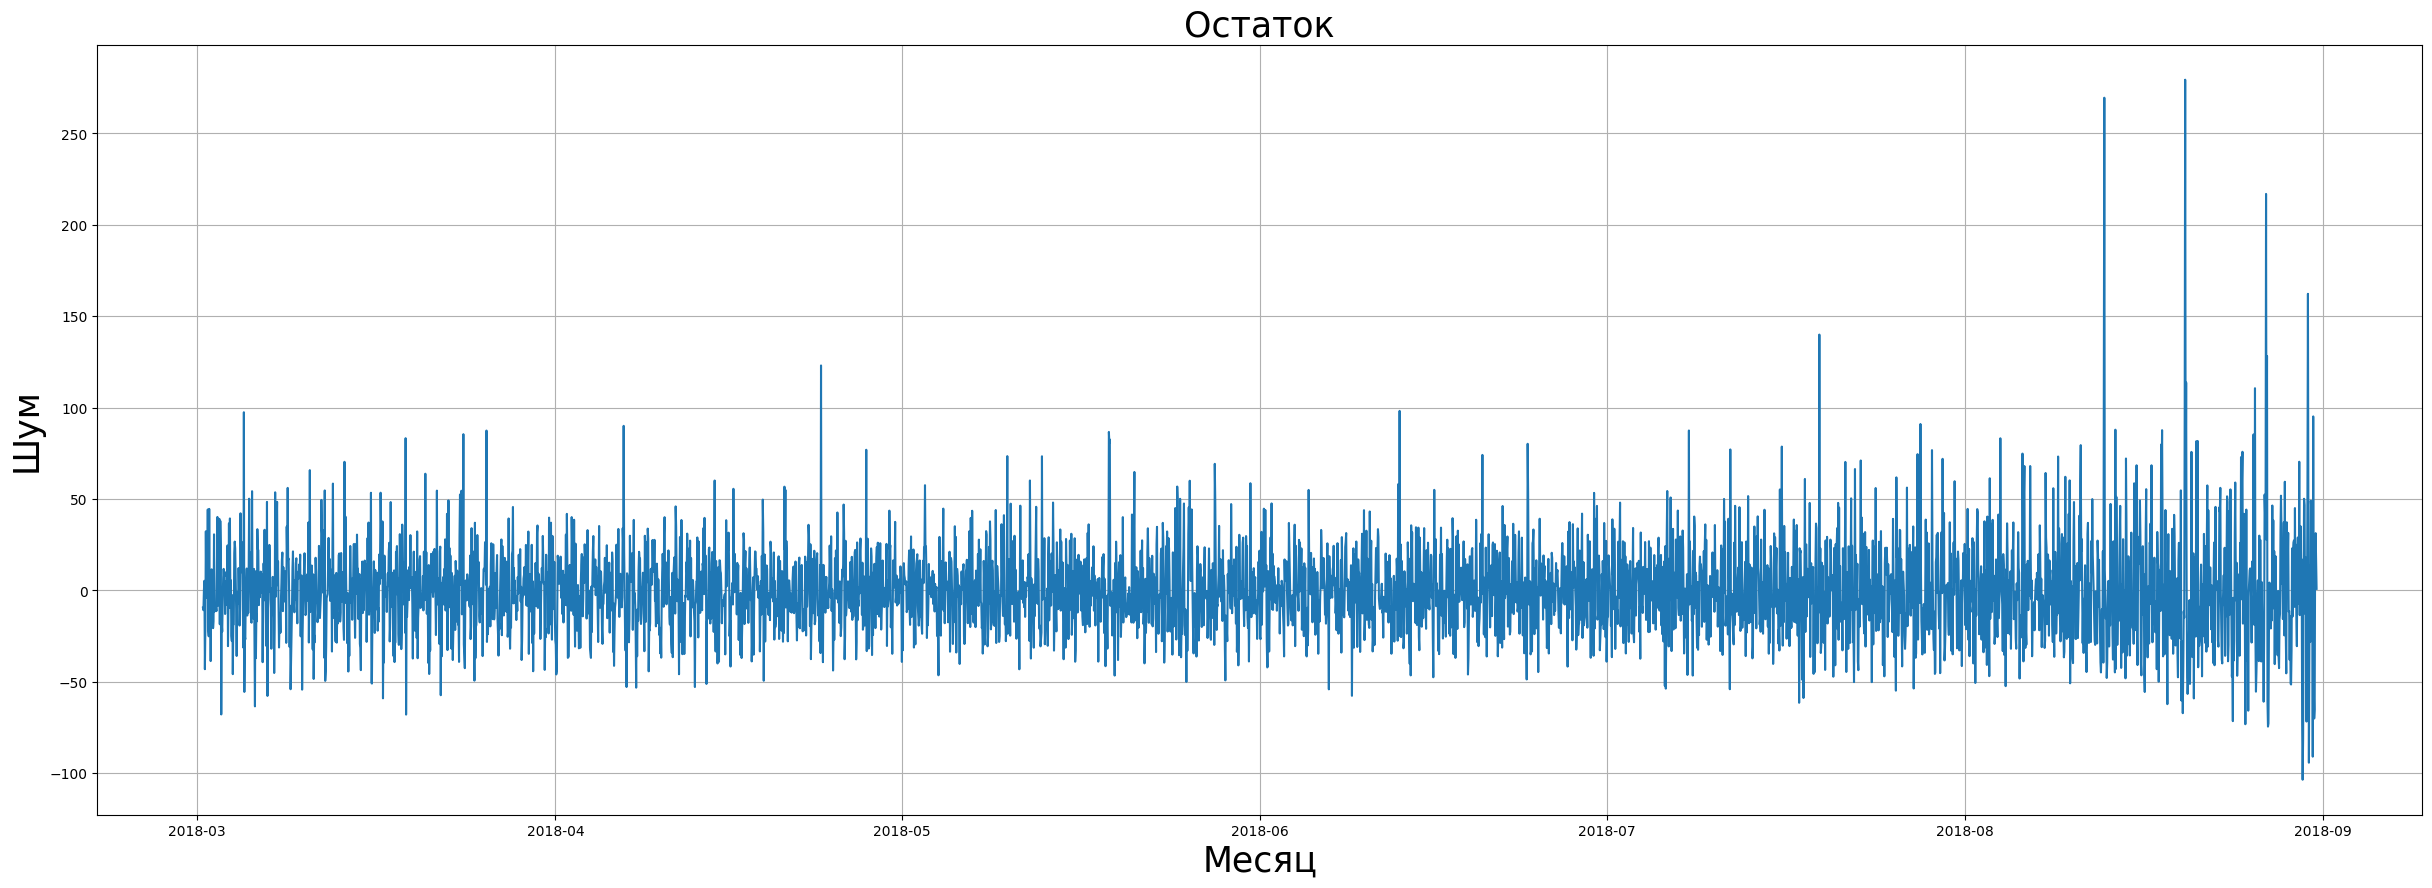

In [13]:
plt.figure(figsize=(30, 10))
plt.plot(decomposed.resid)
plt.title('Остаток', fontsize=25)
plt.xlabel('Месяц', fontsize=25)
plt.ylabel('Шум', fontsize=25)
plt.grid()
plt.show()

In [14]:
# разложение временного ряда на тренд, сезонность и остаток
decomposed = seasonal_decompose(taxi_data_analysis['2018-08-01':'2018-08-31'])

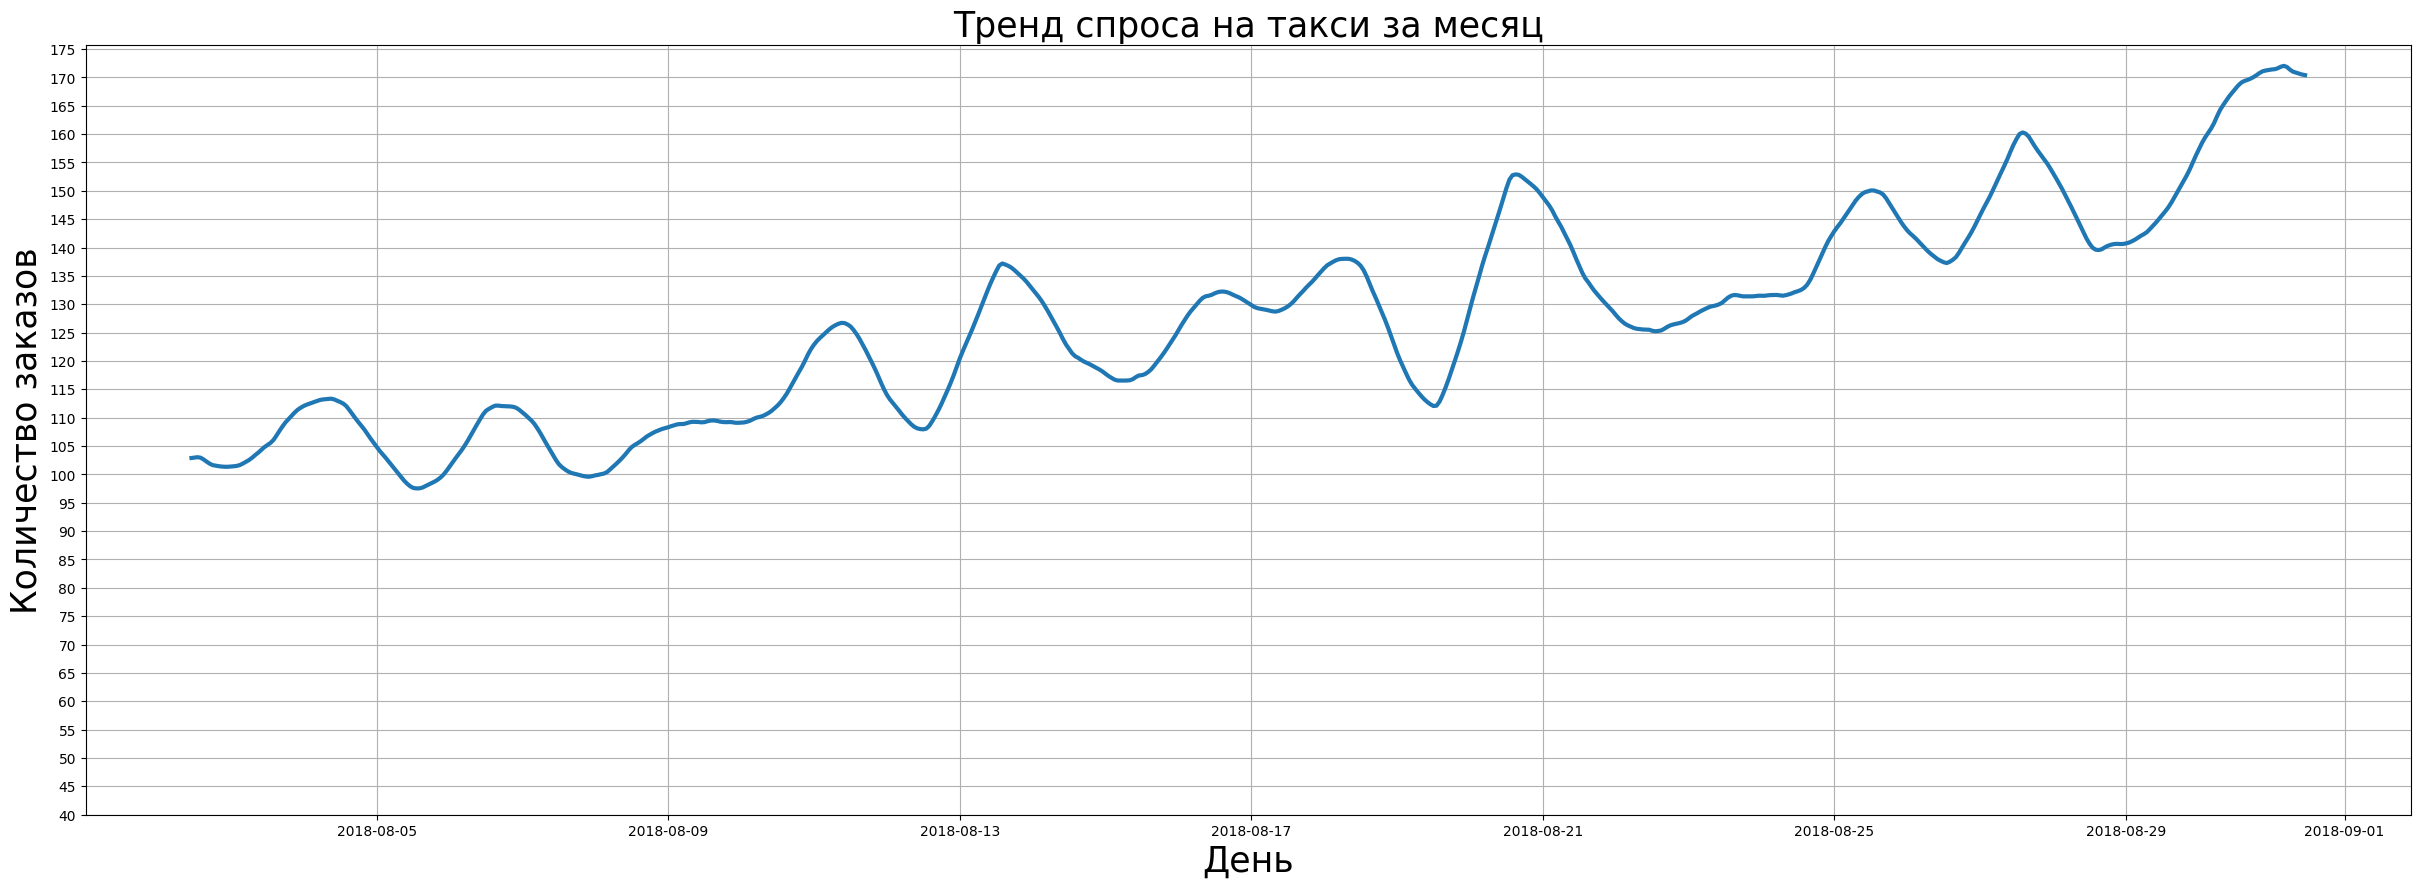

In [15]:
plt.figure(figsize=(30, 10))
plt.plot(decomposed.trend.rolling(24).mean() , linewidth=3)
plt.title('Тренд спроса на такси за месяц', fontsize=25)
plt.xlabel('День', fontsize=25)
plt.ylabel('Количество заказов', fontsize=25)
plt.yticks(np.arange(40, 180, 5))
plt.grid()
plt.show()

In [16]:
# разложение временного ряда на тренд, сезонность и остаток
decomposed = seasonal_decompose(taxi_data_analysis['2018-08-30':'2018-08-31'])

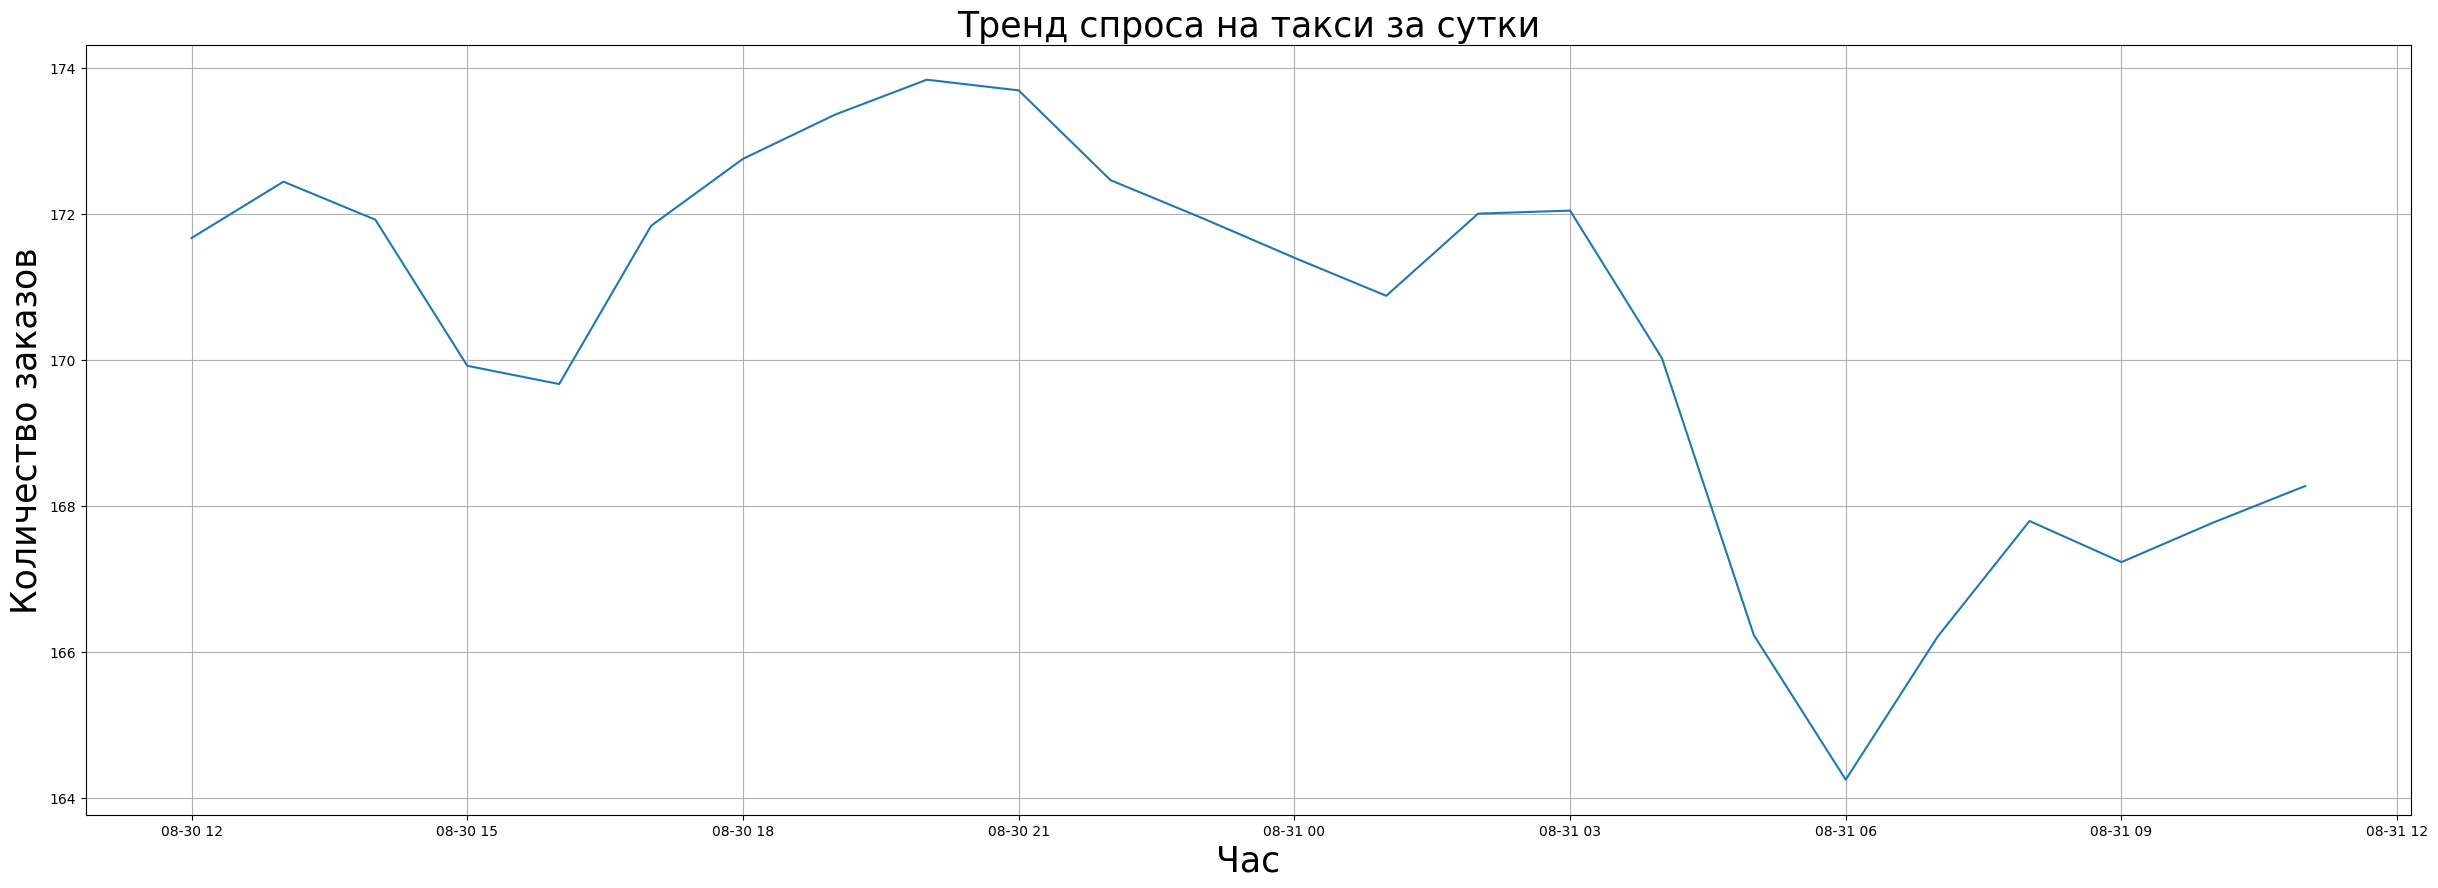

In [17]:
plt.figure(figsize=(30, 10))
plt.plot(decomposed.trend)
plt.title('Тренд спроса на такси за сутки', fontsize=25)
plt.xlabel('Час', fontsize=25)
plt.ylabel('Количество заказов', fontsize=25)
plt.grid()
plt.show()

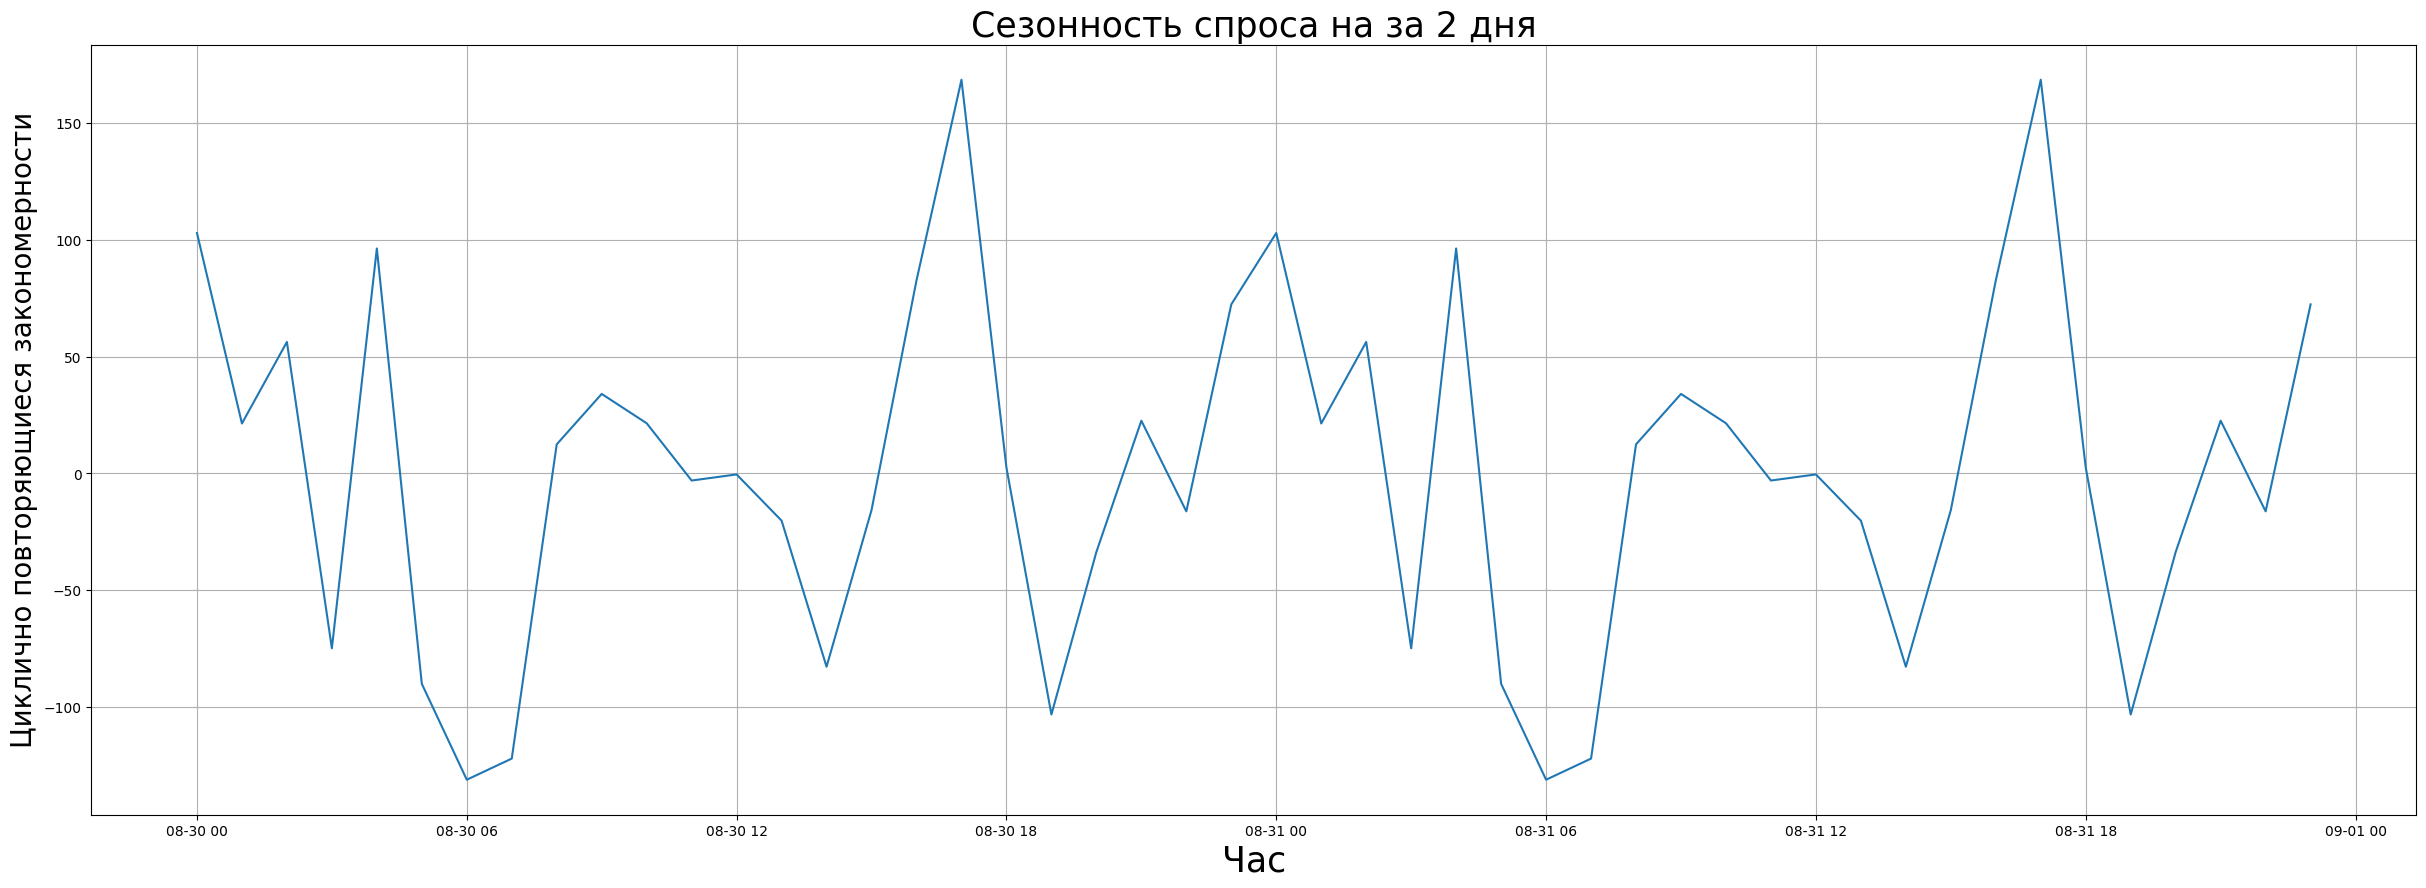

In [18]:
plt.figure(figsize=(30, 10))
plt.plot(decomposed.seasonal)
plt.title('Сезонность спроса на за 2 дня', fontsize=25)
plt.xlabel('Час', fontsize=25)
plt.ylabel('Циклично повторяющиеся закономерности', fontsize=20)
plt.grid()
plt.show()

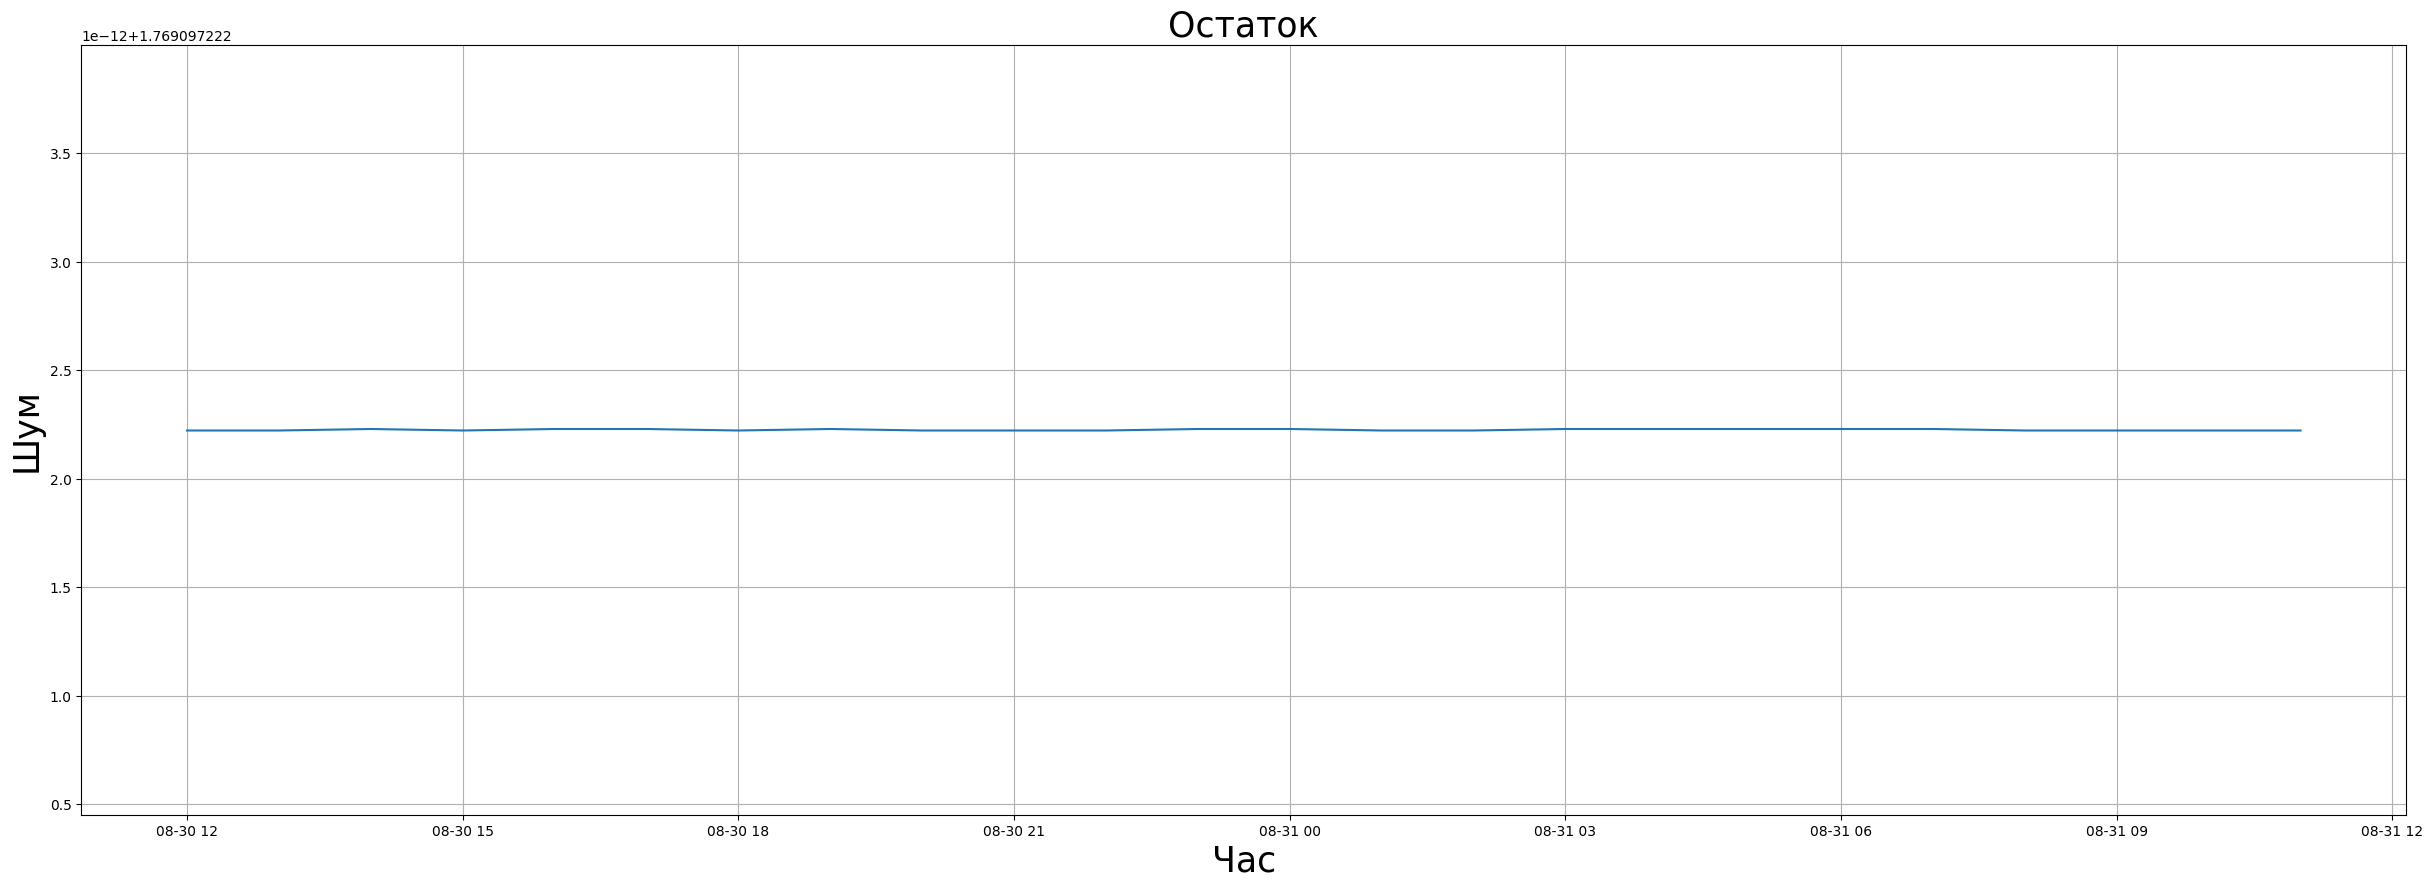

In [19]:
plt.figure(figsize=(30, 10))
plt.plot(decomposed.resid)
plt.title('Остаток', fontsize=25)
plt.xlabel('Час', fontsize=25)
plt.ylabel('Шум', fontsize=25)
plt.grid()
plt.show()

При анализе было выявлено, что общий тренд на спрос такси увеличивается. Присутствует месячная сезонность, в начале месяца имеется не большой спад. В течение дня самый большой спрос в районе 17:00, самый маленький в районе 06:00.

## Обучение

Подготовим признаки и на их основе обучим 3 модели.

In [20]:
# функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    # календарные признаки
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [21]:
# таблица для сбора показателей моделей
table_1 = pd.DataFrame({'Модель': [], 'RMSE': [], 'Параметры модли': [], 'Отстающие значения': [], 'Скользящее среднее': []})

In [22]:
%%time
# счетчики параметров при создании признаков
best_lag1 = 0
best_rolling_size1 = 0
best_rmse1 = 48
# перебор парамеров признаков
for lag in range (1, 51, 5):
    for roll in range(1, 51, 5):        
        data_new_options = make_features(taxi_data.copy(deep=True), lag, roll)
        # удаление NaN
        data_new_options = data_new_options.dropna() 
        # разделение на признаки и целевой признак
        features_train1 = data_new_options.drop(['num_orders'], axis=1)
        target_train1 = data_new_options['num_orders']                        
        # разделение данных на обучающую и тестовую выборки 90|10
        features_train1, features_test1, target_train1, target_test1= train_test_split(features_train1,
                                                                                   target_train1,
                                                                                   shuffle=False,
                                                                                   test_size=0.1,
                                                                      random_state = RANDOM_STATE)
        # создание моди
        model_1=LinearRegression()
        # гиперпараметры для обучение
        parameters={}
        # рассчет RMSE при кросс-валидации
        tuning_model_1=GridSearchCV(model_1,param_grid=parameters,scoring=SCORER, cv = TSS)
        tuning_model_1.fit(features_train1, target_train1)
        # отбор лучших параметров
        rmse = (-tuning_model_1.best_score_) ** 0.5  
        params = tuning_model_1.best_params_
        model_1 = tuning_model_1
        f_train1 = features_train1
        f_test1 = features_test1
        t_train1 = target_train1
        t_test1 = target_test1
        
        if rmse < best_rmse1:
            best_rmse1 = rmse
            best_lag1 = lag
            best_rolling_size1 = roll
            best_params1 = params
            best_model_1 = model_1
            
            best_f_train1 = f_train1
            best_f_test1 = f_test1
            best_t_train1 = t_train1
            best_t_test1 = t_test1
            

# добавление данные в таблицу 
name = 'LinearRegression'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(best_rmse1),
                                     best_params1,
                                     best_lag1,
                                     best_rolling_size1]

# вывод данных о модели
table_1

CPU times: total: 4.39 s
Wall time: 4.13 s


,Модель,RMSE,Параметры модли,Отстающие значения,Скользящее среднее
0,LinearRegression,27.03,{},46,31


In [23]:
%%time
# счетчики параметров при создании признаков
best_lag2 = 0
best_rolling_size2 = 0
best_rmse2 = 48
# перебор парамеров признаков
for lag in range (1, 51, 5):
    for roll in range(1, 51, 5):        
        data_new_options = make_features(taxi_data.copy(deep=True), lag, roll)
        # удаление NaN
        data_new_options = data_new_options.dropna() 
        # разделение на признаки и целевой признак
        features_train2 = data_new_options.drop(['num_orders'], axis=1)
        target_train2 = data_new_options['num_orders']                        
        # разделение данных на обучающую и тестовую выборки 90|10
        features_train2, features_test2, target_train2, target_test2= train_test_split(features_train2,
                                                                                   target_train2,
                                                                                   shuffle=False,
                                                                                   test_size=0.1,
                                                                      random_state = RANDOM_STATE)
        # создание моди
        model_2=RandomForestRegressor(random_state=RANDOM_STATE)
        # гиперпараметры для обучение
        parameters={'n_estimators': range (1, 101, 20),
                    'max_depth' : range (1, 11, 3),
                    'max_features':['sqrt']
                    }
        # рассчет RMSE при кросс-валидации
        tuning_model_2=GridSearchCV(model_2,param_grid=parameters,scoring=SCORER, cv = TSS)
        tuning_model_2.fit(features_train2, target_train2)
        # отбор лучших параметров
        rmse = (-tuning_model_2.best_score_) ** 0.5  
        params = tuning_model_2.best_params_
        model_2 = tuning_model_1
        f_train2 = features_train1
        f_test2 = features_test1
        t_train2 = target_train1
        t_test2 = target_test1
        
        if rmse < best_rmse1:
            best_rmse2 = rmse
            best_lag2 = lag
            best_rolling_size2 = roll
            best_params2 = params
            best_model_2 = model_2
            
            best_f_train2 = f_train2
            best_f_test2 = f_test2
            best_t_train2 = t_train2
            best_t_test2 = t_test2

# добавление данные в таблицу 
name = 'RandomForestRegressor'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(best_rmse2),
                                     best_params2,
                                     best_lag2,
                                     best_rolling_size2]

# вывод данных о модели
table_1

CPU times: total: 29min 9s
Wall time: 29min 10s


,Модель,RMSE,Параметры модли,Отстающие значения,Скользящее среднее
0,LinearRegression,27.03,{},46,31
1,RandomForestRegressor,26.63,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",46,46


In [24]:
%%time
# счетчики параметров при создании признаков
best_lag3 = 0
best_rolling_size3 = 0
best_rmse3 = 48
# перебор парамеров признаков
for lag in range (1, 51, 5):
    for roll in range(1, 51, 5):        
        data_new_options = make_features(taxi_data.copy(deep=True), lag, roll)
        # удаление NaN
        data_new_options = data_new_options.dropna() 
        # разделение на признаки и целевой признак
        features_train3 = data_new_options.drop(['num_orders'], axis=1)
        target_train3 = data_new_options['num_orders']                        
        # разделение данных на обучающую и тестовую выборки 90|10
        features_train3, features_test3, target_train3, target_test3= train_test_split(features_train3,
                                                                                   target_train3,
                                                                                   shuffle=False,
                                                                                   test_size=0.1,
                                                                      random_state = RANDOM_STATE)
        # создание моди
        model_3=LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)
        # гиперпараметры для обучение
        parameters={'n_estimators' : range (50, 201, 50),
                    'num_leaves' : range (20, 101, 20)
                    }
        # рассчет RMSE при кросс-валидации
        tuning_model_3=GridSearchCV(model_3,param_grid=parameters,scoring=SCORER, cv = TSS)
        tuning_model_3.fit(features_train3, target_train3)
        # отбор лучших параметров
        rmse = (-tuning_model_3.best_score_) ** 0.5  
        params = tuning_model_3.best_params_
        model_3 = tuning_model_3
        f_train3 = features_train3
        f_test3 = features_test3
        t_train3 = target_train3
        t_test3 = target_test3
        
        if rmse < best_rmse1:
            best_rmse3 = rmse
            best_lag3 = lag
            best_rolling_size3 = roll
            best_params3 = params
            best_model_3 = model_3
            
            best_f_train3 = f_train3
            best_f_test3 = f_test3
            best_t_train3 = t_train3
            best_t_test3 = t_test3

# добавление данные в таблицу 
name = 'LGBMRegressor'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(best_rmse3),
                                     best_params3,
                                     best_lag3,
                                     best_rolling_size3]

# вывод данных о модели
table_1

CPU times: total: 1h 45min 2s
Wall time: 13min 19s


,Модель,RMSE,Параметры модли,Отстающие значения,Скользящее среднее
0,LinearRegression,27.03,{},46,31
1,RandomForestRegressor,26.63,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",46,46
2,LGBMRegressor,24.96,"{'n_estimators': 100, 'num_leaves': 60}",46,46


Было обучено 3 модели. Лучшие показатели у LGBMRegressor.  
RMSE 24.96  
Параметры модли	{'n_estimators': 100, 'num_leaves': 60}  
Отстающие значения 46  
Скользящее среднее 46

## Тестирование

Проверим модель на тестовой выборке и на адекватность сравнив с предсказаниями среднего.

In [25]:
# рассчитаем финальное RMSE для тестовой выборки на лучшей модели
predictions = best_model_3.predict(best_f_test3)
rmse = mean_squared_error(best_t_test3, predictions) ** .5
name = 'BestModelTest'
# перенос данных из лучшей модели 
best_lag = best_lag3
best_rolling_size = best_rolling_size3
best_params = best_params3
# добавление данные в таблицу 
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(rmse),
                                     best_params,
                                     best_lag,
                                     best_rolling_size]

# вывод данных о модели
table_1

,Модель,RMSE,Параметры модли,Отстающие значения,Скользящее среднее
0,LinearRegression,27.03,{},46,31
1,RandomForestRegressor,26.63,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",46,46
2,LGBMRegressor,24.96,"{'n_estimators': 100, 'num_leaves': 60}",46,46
3,BestModelTest,41.30,"{'n_estimators': 100, 'num_leaves': 60}",46,46


In [26]:
# рассчитаем финальное RMSE для тестовой выборки на проверочной модели
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(best_f_train3, best_t_train3)

dummy_test_predictions = dummy_model.predict(best_f_test3)

rmse = mean_squared_error(best_t_test3, dummy_test_predictions) ** .5
name = 'DummyRegressor'
best_lag = best_lag3
best_rolling_size = best_rolling_size3
best_params = best_params3
# добавление данные в таблицу 
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(rmse),
                                     best_params,
                                     best_lag,
                                     best_rolling_size]

# выводим данные о модели
table_1

,Модель,RMSE,Параметры модли,Отстающие значения,Скользящее среднее
0,LinearRegression,27.03,{},46,31
1,RandomForestRegressor,26.63,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",46,46
2,LGBMRegressor,24.96,"{'n_estimators': 100, 'num_leaves': 60}",46,46
3,BestModelTest,41.30,"{'n_estimators': 100, 'num_leaves': 60}",46,46
4,DummyRegressor,84.73,"{'n_estimators': 100, 'num_leaves': 60}",46,46


In [27]:

train, test = train_test_split(taxi_data, shuffle=False, test_size=0.2)

pred_previous = np.ones(test.shape) * test.shift(fill_value=train.iloc[-1,-1])

rmse = mean_squared_error(test, pred_previous) ** .5
name = 'Сравнение с предыдущим'
best_lag = 'NaN'
best_rolling_size = 'NaN'
best_params = 'NaN'
# добавление данные в таблицу 
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(rmse),
                                     best_params,
                                     best_lag,
                                     best_rolling_size]

In [28]:
table_1

,Модель,RMSE,Параметры модли,Отстающие значения,Скользящее среднее
0,LinearRegression,27.03,{},46,31
1,RandomForestRegressor,26.63,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",46,46
2,LGBMRegressor,24.96,"{'n_estimators': 100, 'num_leaves': 60}",46,46
3,BestModelTest,41.30,"{'n_estimators': 100, 'num_leaves': 60}",46,46
4,DummyRegressor,84.73,"{'n_estimators': 100, 'num_leaves': 60}",46,46
5,Сравнение с предыдущим,53.37,NaN,NaN,NaN


Тестирование показало, что лучшая модель предсказывает точнее, чем модель высчитывающая среднее, поэтому ее можно считать адекватной.

**Вывод**
- В данных не имеют пропусков и дубликатов.
- Данные были преобразованы и проанализированы по временной шкале, в результате чего были выявлены тренд и сезонность.
- Произведена обработка данных. Выполнено обучение 3 моделей и сбор параметров их работы на основе которых выбрана лучшая LGBMRegressor. 
- Произведено сравнение результатов LGBMRegressor и DummyRegressor на тестовой выборке. Модель адекватна и показывает требуемую точность установленной метрики. 
- Рекомендую LGBMRegressor для использования в качестве модели предсказания спроса на такси.